In [1]:
# data format: city, state usps code, list of counties
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
from sklearn.metrics import mean_squared_error
from skmob.models import Gravity
import statsmodels.api as sm

def compute_weights(network, job_column):
    comp_aggs={job_column: 'sum'}
    # outgoing=False corresponds to jobs, outgoing=True corresponds to population 
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={job_column: 'jobs'})
    residence = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={job_column: 'residence'})
    edges = network.edges
    
    edges_with_weights = edges.join(residence, on='origin').join(jobs, on='destination')
    return edges_with_weights
    
def fit_gravity_model(edges, job_column):
    copy = edges.copy()
    # replace zero values with 1
    copy.loc[(copy['jobs'] == 0), 'jobs'] = 1 
    copy.loc[(copy['residence'] == 0), 'residence'] = 1 
    copy.loc[(copy['distance'] == 0), 'distance'] = 1 
    
    X = sm.add_constant(np.log(copy.distance))
    y = np.log(copy[job_column]) - np.log(copy.jobs) - np.log(copy.residence)
    
    model = sm.OLS(y, X).fit()
    return model

def extract_model_exponents(network):
    columns = ['SE01', 'SE03']
    with_distance = add_distance(network)
    filtered_network = with_distance.filter_edges((with_distance.edges.SE01 > 0) & (with_distance.edges.SE03 > 0))
                                             
    result = {}
    for column in columns:
        with_weights = compute_weights(filtered_network, column)
        model = fit_gravity_model(with_weights, column)
        conf_interval = model.conf_int(alpha=0.05, cols=None).loc['distance']
        result[column] = model.params[1]
        result[column + '_error'] = model.params[1] - conf_interval[0]
        # variance = SD^2
        result[column + '_variance'] = model.bse[1] * model.bse[1]
    
    return result

In [ ]:
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
provider = OriginDestinationEmploymentDataProvider()

model_weights = {}
for city, state, conties in cities:
    print('Processing {city}'.format(city=city))
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    zip_city_network = city_network.group_nodes('zip')
    city_network = zip_city_network.agg_parallel_edges(column_aggs={'S000': 'sum', 'SE01': 'sum', 'SE02': 'sum', 'SE03': 'sum'})
    exponents = extract_model_exponents(city_network)
    model_weights[city] = exponents

## Compute CCDF values

In [6]:
from statistics import NormalDist

df = pd.DataFrame(model_weights).transpose()
df['exponent_diff'] = df.SE03 - df.SE01
# SD(high_exp - low_exp) = Srqt(Var(high_exp) + Var(low_exp))
df['exponent_diff_sigma'] = np.sqrt(df['SE01_variance'] + df['SE03_variance'])
# The Null hypothesis: exponents are the same for low and high-income groups
# Under the Null hypothesis the exponent difference is a normally distributed variable with zero mean
# We compute H0 p-value using the two tailed hypothesis test: p-val = CDF(-exp_diff) + CCDF(exp_diff)
df['p_value'] = df.apply(lambda x: 1 - NormalDist(mu=0, sigma=x['exponent_diff_sigma']).cdf(abs(x['exponent_diff'])) + NormalDist(mu=0, sigma=x['exponent_diff_sigma']).cdf(-abs(x['exponent_diff'])), axis=1)
df[['SE01', 'SE03', 'exponent_diff', 'p_value']].style.format({'p_value': "{:.5%}"})

,SE01,SE03,exponent_diff,p_value
New York City,-0.918541,-0.712740,0.205801,0.00000%
Los Angeles,-1.039514,-1.055264,-0.015749,1.80759%
Chicago,-1.100565,-1.017542,0.083023,0.00000%
Houston,-0.952498,-0.891831,0.060667,0.00000%
Boston,-0.941609,-0.759276,0.182333,0.00000%
Phoenix,-0.805435,-0.751514,0.053921,0.00088%
Philadelphia,-0.795225,-0.612299,0.182926,0.00000%
San Antonio,-0.709283,-0.583269,0.126014,0.00000%
San Diego,-1.064132,-0.969178,0.094954,0.00000%
Dallas,-0.836295,-0.793016,0.043278,1.57667%


## Visualize exponents and confidence intervals

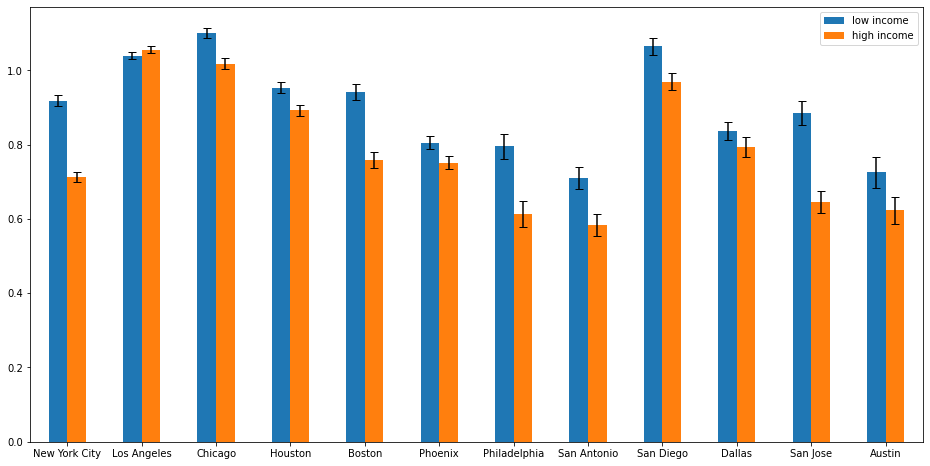

In [5]:
exponents = df[['SE01', 'SE03']].copy()
exponents.SE01 = -exponents.SE01
exponents.SE03 = -exponents.SE03
exponents = exponents.rename(columns={'SE01':'low income', 'SE03':'high income'})
errors = df[['SE01_error', 'SE03_error']].rename(columns={'SE01_error':'low income','SE03_error':'high income'})

fig, ax = plt.subplots(figsize=(16,8))
exponents.plot.bar(yerr=errors, ax=ax, capsize=4, rot=0);

## Visualize the difference between low and high income exponents

<AxesSubplot:xlabel='City', ylabel='p-value'>

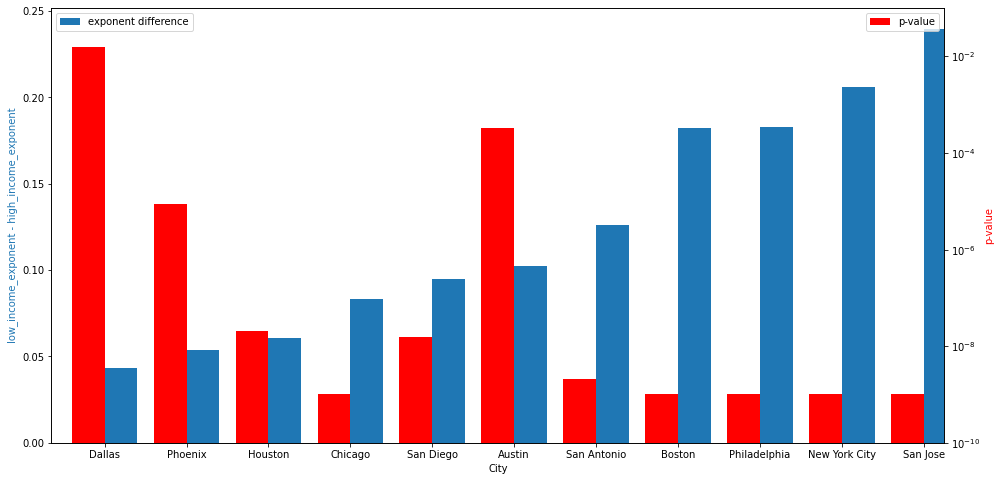

In [12]:
delta = df[df.index != 'Los Angeles'].sort_values('exponent_diff').reset_index().rename(columns={'index':'City'})
delta['p_value'] = delta['p_value'].clip(0.000000001, None)
fig, ax = plt.subplots(figsize=(16,8))
ax.set_ylabel('low_income_exponent - high_income_exponent', color="#1f77b4")
delta.plot.bar(x='City', y='exponent_diff', ax=ax, capsize=4, rot=0, label='exponent difference', position=0, width=0.4)
ax2=ax.twinx()
ax2.set_ylabel('p-value', color="red")
ax2.set_yscale('log')
ax2.set_ylim([0.0000000001, 0.1])
delta.plot.bar(x='City', y='p_value', ax=ax2, capsize=4, rot=0, label='p-value', position=1, color='red', width=0.4)